In [1]:
%matplotlib inline

Training a visual object classifier for CIFAR10 dataset
============================================

We use a package called ``torchvision``, that has data loaders for common datasets.

We will use the CIFAR10 dataset:
- It has the object classes (we use below a 5 character prefix as class names): 
        ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
- The images in CIFAR-10 are of size 3x32x32: 3-channel color images of 32x32 pixels in size.

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# Set the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Creating Data Pipeline
--------------------------------

1. Define a transformation: each pixel is represented as a value in [0,1] which is transformed to [-1,1]
2. Create train set and test set loaders
3. Create a list of class names.

In [4]:
batch_size = 256
num_workers = 2

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

classes = []
for c in testset.classes:
    classes.append(c[0:5])
print(classes)

Files already downloaded and verified
Files already downloaded and verified
['airpl', 'autom', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Display a few images using the data iterator
-----------------------------------------------------------

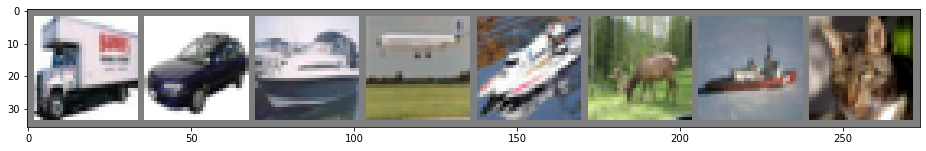

       truck        autom         ship        airpl         ship         deer         ship          cat


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get few random images from tthe training set
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images & print labels  of 8" images 
plt.figure(figsize = (16,16))
imshow(torchvision.utils.make_grid(images[0:8]))
print(' '.join(' %11s' % classes[labels[j]] for j in range(8)))

Define a Convolutional Neural Network
--------------------------------------------------------

We use the following convenions:
- $*$ denotes the convolution operator
- Max-pooling denoted as $\max$ is the maximum over an image patch
- Rectification is denoted as $[z]_+ = \max\{z, 0\}$ performed element wise

Network Architecture
 - $H_1 = \max(X * c1)$
 - $H_2 = \max(H_1 * c2)$
 - $H_3 = [A_1 H_2]_+$ 
 - $H_4 = [A_2 H_3]_+$
 - $out = A_3 H_4$ where $A_3$ is of dimension $|H_3| \times 10$

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Create a network and sent it to device

In [7]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Set a Loss function and optimizer
------------------------------------------------

- Use Cross-Entropy between the predicted class vector and the correct class
- Use SGD with momentum as the optimizer



In [8]:
import torch.optim as optim

erm = nn.CrossEntropyLoss()
sgd = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
adagrad = optim.Adagrad(net.parameters(), lr=0.01)

### Minimal Train function since we defined most of code above

In [9]:
losses = []
def Train(epochs):
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # Get next batch: data is a list of image-label pairs
            inputs, labels = data[0].to(device), data[1].to(device)
            # Zero the gradient as it contains values from previous iteration
            opt.zero_grad()
            # Perform inference for each example in the mini-batch
            outputs = net(inputs)
            # Calculate loss of the mini-batch for the purpose reporting purposes
            loss = erm(outputs, labels)
            # Calculate gradient of mini-batch using Backprop
            loss.backward()
            # Call opt (SGD as defined above) and perform gradient-based upadte
            opt.step()
            epoch_loss += loss.item()
            epoch_steps += 1
        losses.append(epoch_loss / epoch_steps)
        if (epoch + 1) % 1 == 0:
            print('[%2d] loss: %.3f' % (epoch + 1, losses[-1]))
    return losses[-1] > 0.5

### Training procedure
- Run SGD for 10 iterations
- If the loss of the last epoch is still high continue with Adagrad 

In [10]:
opt = sgd
if Train(10 if device.type == 'cuda' else 3):
    opt = adagrad
    _ = Train(10 if device.type == 'cuda' else 3)

[ 1] loss: 1.946
[ 2] loss: 1.492
[ 3] loss: 1.336
[ 4] loss: 1.228
[ 5] loss: 1.139
[ 6] loss: 1.072
[ 7] loss: 1.013
[ 8] loss: 0.966
[ 9] loss: 0.927
[10] loss: 0.884
[ 1] loss: 0.871
[ 2] loss: 0.730
[ 3] loss: 0.689
[ 4] loss: 0.658
[ 5] loss: 0.635
[ 6] loss: 0.614
[ 7] loss: 0.596
[ 8] loss: 0.581
[ 9] loss: 0.567
[10] loss: 0.554


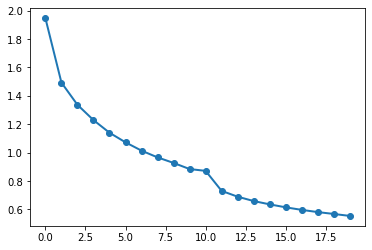

In [11]:
if device.type == 'cuda':
    import matplotlib.pyplot as plt
    plt.plot(losses, linewidth=2, linestyle='-', marker='o')

## Test data evaluation

Set iterator for test data and show images

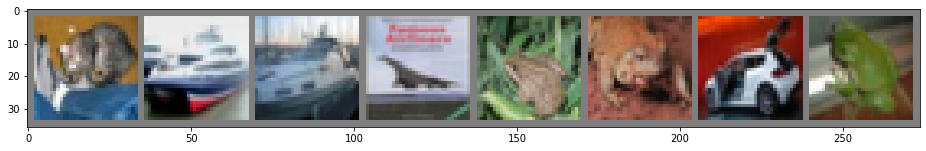

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()
inputs = images.to(device)
plt.figure(figsize = (16,16))
imshow(torchvision.utils.make_grid(images[0:8]))

### Inference & Predictions
1. Perform inference with the trained network. The result is a 10 dimensional vector per example.
2. Make prediction by choosing the largest entry in each inferred vector

In [13]:
outputs = net(inputs)
_, preds = torch.max(outputs, 1)
print('Correct:', ' '.join(' %5s' % classes[labels[j]] for j in range(8)))
print('Predict:', ' '.join(' %5s' % classes[preds[j]] for j in range(8)))

Correct:    cat   ship   ship  airpl   frog   frog  autom   frog
Predict:    cat   ship   ship  airpl   deer   frog  truck   frog


### Calaculate  error rate on test data

Error rate on test data is high (over 40%). It is nonetheless much better than random guessing which would have achieved 10%.

In [14]:
err = 0
tot = 0
with torch.no_grad():
    for data in testloader:
        X, y = data[0].to(device), data[1].to(device)
        p = net(X)
        _, yh = torch.max(p.data, 1)
        tot += y.size(0)
        err += (yh != y).sum().item()
print('Error of the network on test images: %5.2f%%' % (100 * err / tot))

Error of the network on test images: 33.27%


### Evaluate the error per class

For each class $c$ calculate: $$\frac{|\{y_i=c \wedge \hat{y}_i\neq c\}|}{|\{y_i=c\}|} ~ .$$ 


In [15]:
class_err = list(0. for i in range(10))
class_tot = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        X, y = data[0].to(device), data[1].to(device)
        outputs = net(X)
        _, preds = torch.max(outputs, 1)
        c = (preds != y).squeeze()
        for i in range(c.size(0)):
            label = y[i]
            class_err[label] += c[i].item()
            class_tot[label] += 1

for i in range(10):
    print('Error rate of class %10s : %4.1f%%' % (
        classes[i], 100 * class_err[i] / class_tot[i]))

Error rate of class      airpl : 30.4%
Error rate of class      autom : 23.1%
Error rate of class       bird : 43.0%
Error rate of class        cat : 52.4%
Error rate of class       deer : 35.5%
Error rate of class        dog : 50.4%
Error rate of class       frog : 23.8%
Error rate of class      horse : 23.9%
Error rate of class       ship : 26.5%
Error rate of class      truck : 23.7%
